# <center> Лабораторная работа 2.  </center>
## <center> Предсказание пола клиента по транзакциям с помощью нейросетей </center>

## Описание задачи 
### Необходимо предсказывать пол клиента, основываясь на его транзакционных исторических данных. 

###История транзакция находится на сайте [Kaggle](https://www.kaggle.com/c/python-and-analyze-data-final-project/data)

### Вы будете строить предиктивные модели и отправлять результаты своего моделирования на платформу [Kaggle](https://www.kaggle.com/t/e8a939488d274dab9051cce14d5ca952), где и будет оцениваться каждое решение и положение участников. 
### В роли метрики выступает [ROC AUC](https://dyakonov.org/2017/07/28/auc-roc-%D0%BF%D0%BB%D0%BE%D1%89%D0%B0%D0%B4%D1%8C-%D0%BF%D0%BE%D0%B4-%D0%BA%D1%80%D0%B8%D0%B2%D0%BE%D0%B9-%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA/), который и нужно будет оптимизировать.

## Обращение студента

Добрый день/вечер! Это лабораторная работа №1 студента группы 20222, Алексея Паульса

In [ ]:
!pip install https://github.com/ceshine/shap/archive/master.zip

In [ ]:
import pandas as pd
import numpy as np
import re
import shap
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as torch_optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

from tqdm._tqdm_notebook import tqdm_notebook
from warnings import filterwarnings

tqdm_notebook.pandas(desc="Progress:")

In [ ]:
from google.colab import files
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Загрузим наборы данных

* transactions.csv - таблица содержит историю транзакций клиентов банка за один год и три месяца.
* gender_train.csv - таблица содержит информацию по полу для части клиентов, для которых он известен.
* tr_mcc_codes.csv - таблица содержит описание mcc-кодов транзакций.
* tr_types.csv - таблица содержит описание типов транзакций.
*gender_test_kaggle_sample_submission.csv - пример файла для загрузки решения.

In [ ]:
# Считываем данные
tr_mcc_codes = pd.read_csv('/content/drive/MyDrive/НГУ/2 семестр/ММО/Лаб3/data/tr_mcc_codes.csv', sep=';', index_col='mcc_code')
tr_types = pd.read_csv('/content/drive/MyDrive/НГУ/2 семестр/ММО/Лаб3/data/tr_types.csv', sep=';', index_col='tr_type')

transactions = pd.read_csv('/content/drive/MyDrive/НГУ/2 семестр/ММО/Лаб3/data/transactions.csv', index_col='customer_id')
gender_train = pd.read_csv('/content/drive/MyDrive/НГУ/2 семестр/ММО/Лаб3/data/gender_train.csv', index_col='customer_id')
gender_test = pd.read_csv('/content/drive/MyDrive/НГУ/2 семестр/ММО/Лаб3/data/gender_test.csv', index_col='customer_id')
transactions_train = transactions.join(gender_train, how='inner')
transactions_test = transactions.join(gender_test, how='inner')

del transactions

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Сразу выделим день, час и ночь из datetime

Это служебные признаки, необходимые для генерации других

In [ ]:
for df in [transactions_train, transactions_test]:
    df['day'] = df['tr_datetime'].str.split().apply(lambda x: int(x[0]) % 7)
    df['hour'] = df['tr_datetime'].apply(lambda x: re.search(' \d*', x).group(0)).astype(int)
    df['night'] = ~df['hour'].between(6, 22).astype(int)

## Генерация признаков

Для каждого пользователя известен набор транзакций, которые определяются типом транзакции (tr_type), типом торговой точки продавца (mcc_code), потраченными/полученными У.Е. и полом. Term_id - ID торгового терминала. 

Интуитивно понятно, что типы транзаций (ожидаю, что мужчины более активно пользуются "деловыми" транзакциями, а женщины - "хозяйственными" и т.д.) и типы торговой точки (собственно, что покупается - продукты, одежда (есть "женские" и "мужские" магазины), парфюмерия, оружие и т.д.) сильно коррелируют с полом. Предлагаю в первую очередь добавить следующие признаки:

1. Количество транзакций каждого вида
2. Количество mcc каждого вида
3. Аггрегации amount по типам транзакций
4. Аггрегации amount по mcc

In [ ]:
def my_features_creation(x): 
    # Возвращаются только сгенерированные признаки

    features = []
    # Количество транзакций в каждый день недели
    features.append(pd.Series(x['day'].value_counts(normalize=True).add_prefix('day_')))
    # Количество транзакций в каждый час
    features.append(pd.Series(x['hour'].value_counts(normalize=True).add_prefix('hour_')))
    # Количество транзакций в ночное время суток
    features.append(pd.Series(x['night'].value_counts(normalize=True).add_prefix('night_')))
    # Базовые аггрегации по потраченным или полученным УЕ
    features.append(pd.Series(x[x['amount']>0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('positive_transactions_')))
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('negative_transactions_')))
    
    # Среднее количество потраченных/полученных УЕ на транзакции каждого типа
    tmp = x.groupby('tr_type')['amount'].mean()
    tmp.index = tmp.index.map(lambda x: 'tr_type_mean' + str(x))
    features.append(tmp)

    # Сумма потраченных/полученных УЕ на транзакции каждого типа
    tmp = x.groupby('tr_type')['amount'].sum()
    tmp.index = tmp.index.map(lambda x: 'tr_type_sum' + str(x))
    features.append(tmp)

    # Количество транзакций каждого типа
    tmp = x.groupby('tr_type')['amount'].count()
    tmp.index = tmp.index.map(lambda x: 'tr_type_count' + str(x))
    features.append(tmp)

    # Среднее количество потраченных/полученных УЕ на MCC каждого типа
    tmp = x.groupby('mcc_code')['amount'].mean()
    tmp.index = tmp.index.map(lambda x: 'mcc_code_mean' + str(x))
    features.append(tmp)

    # Сумма потраченных/полученных УЕ на MCC каждого типа
    tmp = x.groupby('mcc_code')['amount'].sum()
    tmp.index = tmp.index.map(lambda x: 'mcc_code_sum' + str(x))
    features.append(tmp)

    # Количество MCC каждого типа
    tmp = x.groupby('mcc_code')['amount'].count()
    tmp.index = tmp.index.map(lambda x: 'mcc_code_count' + str(x))
    features.append(tmp)
    
    return pd.concat(features)

In [ ]:
data_train = transactions_train.groupby(transactions_train.index)\
                               .progress_apply(my_features_creation).unstack(-1)
data_test = transactions_test.groupby(transactions_test.index)\
                             .progress_apply(my_features_creation).unstack(-1)

Progress::   0%|          | 0/8400 [00:00<?, ?it/s]

Progress::   0%|          | 0/3600 [00:00<?, ?it/s]

После добавления новых признаков появились пропущенные значения, а также не совпадает количество признаков в train и test:

In [ ]:
print("Признаков в train:", len(data_train.columns))
print("Признаков в test:", len(data_test.columns))
print("Признаков в train, которых нет в test:", len(set(data_train.columns) - set(data_test.columns)))
print("Признаков в test, которых нет в train", len(set(data_test.columns) - set(data_train.columns)))

Признаков в train: 825
Признаков в test: 819
Признаков в train, которых нет в test: 9
Признаков в test, которых нет в train 3


Починим это:

In [ ]:
# Fix unmatching features
data_test[list(set(data_train.columns) - set(data_test.columns))] = 0
data_test = data_test.drop(list(set(data_test.columns) - set(data_train.columns)), axis=1)

# Fix NA values
data_train.fillna(0, inplace=True)
data_test.fillna(0, inplace=True)

Так как мы работаем с нейросетью, то фичи нужно отнормировать:

In [ ]:
scaler = StandardScaler()

scaler.fit(data_train)

data_train = pd.DataFrame(scaler.transform(data_train), index=data_train.index, 
                          columns=data_train.columns)
data_test = pd.DataFrame(scaler.transform(data_test), index=data_test.index, 
                          columns=data_test.columns)

Ну и наконец-то заведем таргет:

In [ ]:
target = data_train.join(gender_train, how='inner')['gender']

## Model Engineering

Теперь можно приступать к model engineering

Что нужно попробовать:
- Обучить нейронную сеть из одного слоя. Оценить влияние на качество классификации числа нейронов и функции активации.
- Подобрать архитектуру нейронной сети, при которой качество классификации является наибольшим, варьируя число слоев, число нейронов, функцию активации.
- Исследовать влияние dropout на устойчивость работы нейронной сети.
- Определить наиболее информативные признаки.
- Сравнить точность нейронной сети на обучающей и тестовой выборке с помощью ROC AUC по сравнению с другими методами классификации.

Заведем объект для опционального использования CPU/GPU

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Оценивать разные варианты архитектуры будем с помощью разбиения на обучающую и валидационную выборки

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(data_train, target, test_size=0.30, random_state=42)

Для удобной работы заведем специальные для загрузчики для выборок:


In [ ]:
train_dataset = TensorDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(torch.tensor(X_val.values, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.float32))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)



Базовый вариант архитектуры сети - с возможностью выбирать количество слоев, нейронов в скрытых слоях и промежуточную функцию активации

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, 
                 input_size, 
                 num_layers=1, 
                 layer_size=100,
                 activation=F.relu):
        super().__init__()
        
        # Инициализирируем слои
        self.input_layer = nn.Linear(input_size, layer_size)
        self.layers = []
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(layer_size, layer_size))
        # ModuleList нужен для того, чтобы to() применялся к модели корректно
        self.layers = nn.ModuleList(self.layers)
        self.output_layer = nn.Linear(layer_size, 1)
        
        # Инициализируем функцию активации
        self.activation = activation

    def forward(self, input):
        output = self.activation(self.input_layer(input))
        for layer in self.layers:
            output = self.activation(layer(output))
        output = self.output_layer(output)
        
        return output

Функция для обучения модели. Основные моменты:

* В качестве функции потерь используется BCEWithLogitsLoss

* Чтобы интерпретировать выход сети как вероятность класса "1", нужно применить сигмоиду. Чтобы интерпретировать как метку класса - нужно окруклить до ближайшего значения (0 или 1)

* Оптимизатор - Adam

* Для удобства прикручена визуализация изменения лосса и метрики от эпохи - предлагаю оценивать качество различных конфигураций визуально, а не настраивая early stopping и другие колбеки

In [ ]:
def train_model(model, 
                train_dataloader, 
                val_dataloader,
                device, 
                num_epochs = 10,
                lr = 10e-5,
                show=True):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch_optim.Adam(parameters, lr=lr)

    loss_function = nn.BCEWithLogitsLoss()

    train_losses = []
    train_roc_aucs = []
    val_losses = []
    val_roc_aucs = []
    for e in range(num_epochs):
        model.train()

        epoch_train_loss = 0
        epoch_train_roc_auc = 0

        for X_batch, y_batch in train_dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            
            y_pred = model(X_batch)
            
            loss = loss_function(y_pred, y_batch.unsqueeze(1))
            roc_auc = roc_auc_score(y_batch.unsqueeze(1).ravel().cpu(), 
                                    torch.sigmoid(y_pred).ravel().cpu().detach().numpy())
            
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
            epoch_train_roc_auc += roc_auc.item()

        model.eval()
            
        epoch_val_loss = 0
        epoch_val_roc_auc = 0

        for X_batch, y_batch in val_dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = model(X_batch)
            
            loss = loss_function(y_pred, y_batch.unsqueeze(1))
            roc_auc = roc_auc_score(y_batch.unsqueeze(1).ravel().cpu(), 
                                    torch.sigmoid(y_pred).ravel().cpu().detach().numpy())

            epoch_val_loss += loss.item()
            epoch_val_roc_auc += roc_auc.item()
        
        train_losses.append(epoch_train_loss / len(train_dataloader))
        train_roc_aucs.append(epoch_train_roc_auc / len(train_dataloader))
        val_losses.append(epoch_val_loss / len(val_dataloader))
        val_roc_aucs.append(epoch_val_roc_auc / len(val_dataloader))

    if show:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
        x = range(len(train_losses))
        ax1.plot(x, train_losses, label='Train')
        ax1.plot(x, val_losses, label='Val')
        ax1.set_title('Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax2.plot(x, train_roc_aucs, label='Train')
        ax2.plot(x, val_roc_aucs, label='Val')
        ax2.set_title('Metric (ROC AUC)')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('ROC AUC')
        ax2.legend()
        plt.show()

    return np.array(val_roc_aucs).max()

In [ ]:
def test_layer_size(layer_size, num_layers=1, activation=F.relu, num_epochs=10, show=True):
    if show:
        print(f"Нейронов в скрытом слое: {layer_size}, функция активации: {str(activation)}")
    model = NeuralNetwork(X_train.shape[1], num_layers=num_layers, layer_size=layer_size, activation=activation)
    model.to(device)
    best_metric = train_model(model, train_dataloader, val_dataloader, device, num_epochs=num_epochs, show=show)
    if show:
        print(f"Лучший результат на валидации: {best_metric}")
    return best_metric

### Один скрытый слой

Итак, в нейросети только один скрытый слой. Посмотрим на различное количество нейронов и функции активации для нормального количества нейронов

Начнем с количества нейронов в скрытом слое:

Нейронов в скрытом слое: 1, функция активации: <function relu at 0x7f7baeda3ef0>


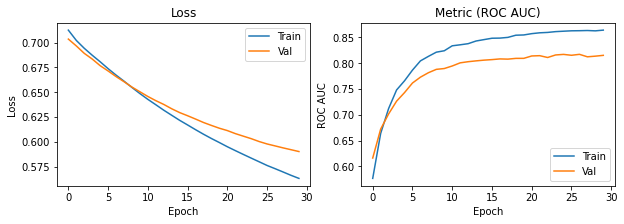

Лучший результат на валидации: 0.8171885492953486


In [ ]:
test_layer_size(1, num_epochs=30);

Нейронов в скрытом слое: 5, функция активации: <function relu at 0x7f7baeda3ef0>


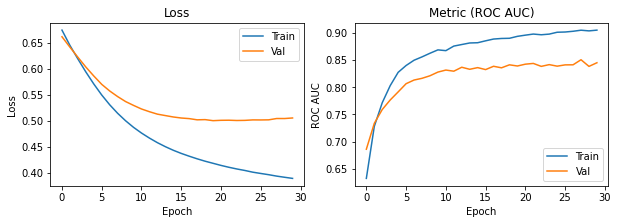

Лучший результат на валидации: 0.850422768534474


In [ ]:
test_layer_size(5, num_epochs=30);

Нейронов в скрытом слое: 10, функция активации: <function relu at 0x7f7baeda3ef0>


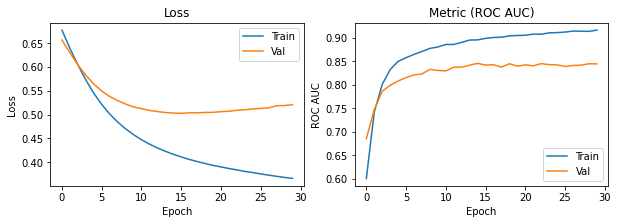

Лучший результат на валидации: 0.845776369442663


In [ ]:
test_layer_size(10, num_epochs=30);

Нейронов в скрытом слое: 25, функция активации: <function relu at 0x7f7baeda3ef0>


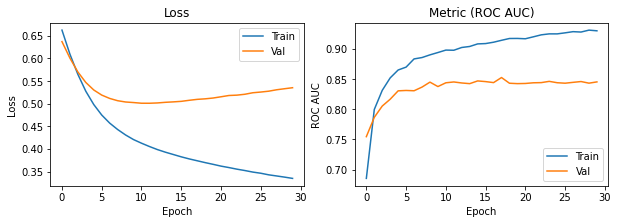

Лучший результат на валидации: 0.8526691906054938


In [ ]:
test_layer_size(25, num_epochs=30);

Нейронов в скрытом слое: 50, функция активации: <function relu at 0x7f7baeda3ef0>


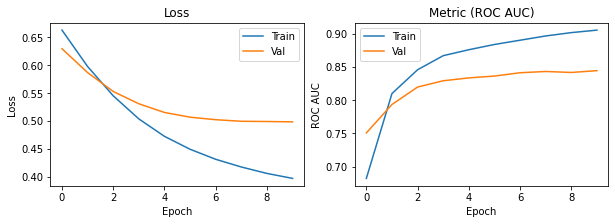

Лучший результат на валидации: 0.8442868333105978


In [ ]:
test_layer_size(50);

Нейронов в скрытом слое: 100, функция активации: <function relu at 0x7f7baeda3ef0>


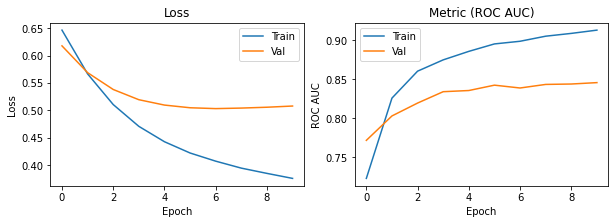

Лучший результат на валидации: 0.8457842137016311


In [ ]:
test_layer_size(100);

Нейронов в скрытом слое: 250, функция активации: <function relu at 0x7f7baeda3ef0>


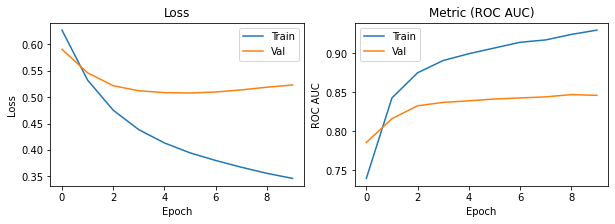

Лучший результат на валидации: 0.8469186587060702


In [ ]:
test_layer_size(250);

Нейронов в скрытом слое: 500, функция активации: <function relu at 0x7f7baeda3ef0>


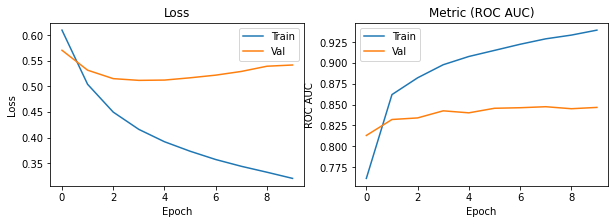

Лучший результат на валидации: 0.8474989911620052


In [ ]:
test_layer_size(500);







Нейронов в скрытом слое: 1000, функция активации: <function relu at 0x7f7baeda3ef0>


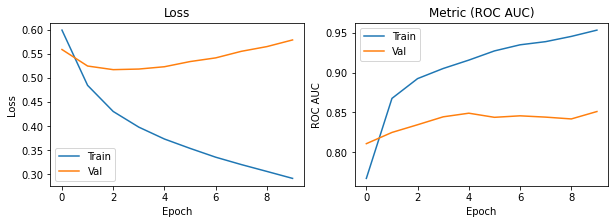

Лучший результат на валидации: 0.8511857042886167


In [ ]:
test_layer_size(1000);

Вывод по подбору размера скрытого слоя:

Результат примерно одинаковый, уже одного нейрона в скрытом слое достаточно, чтобы выйти на уровень обычных линейных алгоритмов. Но больше нейронов, конечно, лучше

На самом деле, результат довольно сильно зависит от случая - для одного нейрона можно получить как 0.81, так и 0.76. В идеале, чтобы исследовать точные границы точности, среднее и дисперсию, нужно провести множество повторяющихся экспериментов для каждого набора параметров. Но для анализа общих закономерностей хватает и таких графиков

Чем больше нейронов, тем быстрее в плане количества эпох обучается модель ("конец" обучения можно выделить как момент, когда лосс на валидации начинается увеличиваться, а точность почти не растет)

Теперь посмотрим на влияние функции активации (в прошлом эксперименте использовалась ReLU):

Нейронов в скрытом слое: 50, функция активации: <function relu at 0x7f7baeda3ef0>


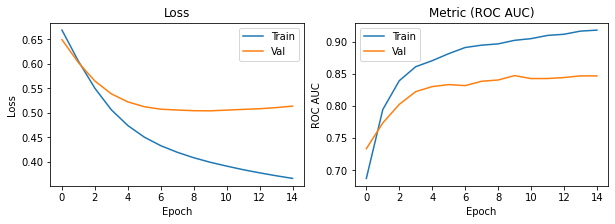

Лучший результат на валидации: 0.8472056649237775


In [ ]:
test_layer_size(50, activation=F.relu, num_epochs=15)

Нейронов в скрытом слое: 50, функция активации: <function elu at 0x7f7baeda6170>


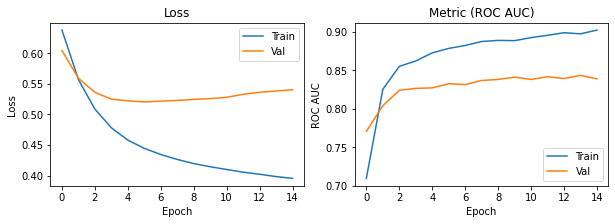

Лучший результат на валидации: 0.8435154970129286


In [ ]:
test_layer_size(50, activation=F.elu, num_epochs=15)

Нейронов в скрытом слое: 50, функция активации: <built-in method sigmoid of type object at 0x7f7ca0ed9e80>


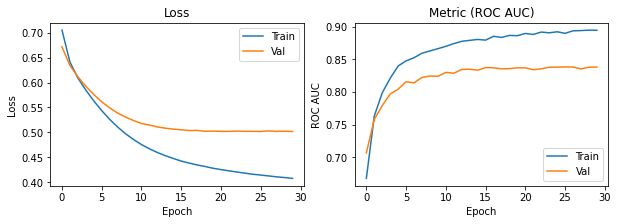

Лучший результат на валидации: 0.8381618053137049


In [ ]:
test_layer_size(50, activation=torch.sigmoid, num_epochs=30)

Нейронов в скрытом слое: 50, функция активации: <function softsign at 0x7f7baeda6680>


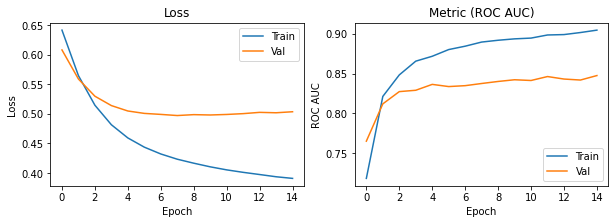

Лучший результат на валидации: 0.8474773039425847


In [ ]:
test_layer_size(50, activation=F.softsign, num_epochs=15)






Нейронов в скрытом слое: 50, функция активации: <built-in method tanh of type object at 0x7f7ca0ed9e80>


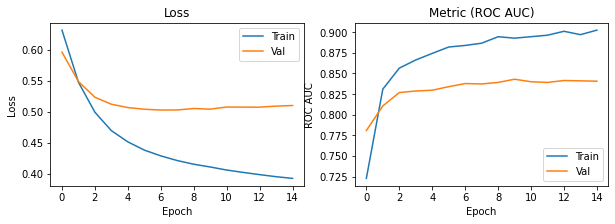

Лучший результат на валидации: 0.8429563445948278


In [ ]:
test_layer_size(50, activation=torch.tanh, num_epochs=15)

Нейронов в скрытом слое: 50, функция активации: <function hardshrink at 0x7f7baeda6560>


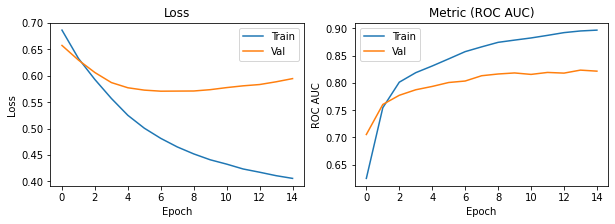

Лучший результат на валидации: 0.8234809065643415


In [ ]:
test_layer_size(50, activation=F.hardshrink, num_epochs=15)

Вывод по подбору функции активации:

Результаты почти одинаковые, кроме Hardshring - с ним результаты хуже. У сигмоиды более плавное обучение, нужно больше эпох

В целом же, разницы в рамках данной задачи и архитектуры нет

### Оптимальная архитектура

Попробуем подобрать оптимальную архитектуру нейросети

Варьировать функцию активации не вижу смысла, вместо этого предлагаю посмотреть на BatchNorm

Сначала попробуем простейшую архитектуру - несколько линейных слоев подряд с одинаковым количеством нейронов



In [ ]:
results = []
for num_layers in tqdm_notebook([1, 2, 3, 5, 10, 15]):
    for layer_size in [1, 5, 15, 50, 100, 1000]:
        cur_results = []
        # Усредним значение качества модели по нескольким запускам
        for _ in range(5):
            res = test_layer_size(layer_size=layer_size, num_layers=num_layers, num_epochs=15, show=False)
            cur_results.append(res)
        
        cur_results = np.array(cur_results)
        results.append([cur_results.mean(), cur_results.std(), num_layers, layer_size])

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
results.sort(key=lambda x: x[0])
results

[[0.5, 0.0, 15, 1],
 [0.5627986288059703, 0.12559725761194057, 10, 1],
 [0.5756951690029466, 0.09730449014334369, 5, 1],
 [0.6991056448247667, 0.10266801286002389, 2, 1],
 [0.7263446399090735, 0.11406761662765134, 3, 1],
 [0.7593482695341901, 0.12804409882149578, 10, 5],
 [0.7869155823419642, 0.026754133724944864, 1, 1],
 [0.8101560204188211, 0.022646184235202725, 15, 5],
 [0.8233898098763047, 0.007037949612248255, 5, 5],
 [0.8260106251475541, 0.005270040215647053, 3, 5],
 [0.8284554720856351, 0.005670452039159427, 1, 5],
 [0.8325408254853153, 0.004402107044880316, 2, 5],
 [0.8387126525993229, 0.002864863288501679, 15, 100],
 [0.8397468398466315, 0.000795540199261112, 10, 100],
 [0.8399579400178403, 0.002445710311351763, 15, 15],
 [0.8400719934536613, 0.0035845655841158985, 15, 50],
 [0.8400784366608665, 0.002131157479991925, 10, 15],
 [0.8403727177925019, 0.0013095418809113447, 10, 1000],
 [0.8404323064966691, 0.0006866490348782892, 15, 1000],
 [0.8420989803377813, 0.00181745633392809

Забавно - количество линейных слоев одинакового размера не влияет положительно на качество. При большем количестве слоев обучение идет быстрее:

Нейронов в скрытом слое: 100, функция активации: <function relu at 0x7fde02409e60>


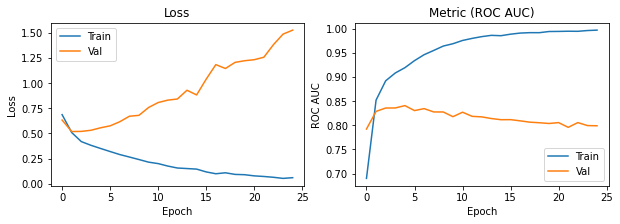

Лучший результат на валидации: 0.8405448512482359


In [ ]:
test_layer_size(layer_size=100, num_layers=10, num_epochs=25, show=True);

Нейронов в скрытом слое: 100, функция активации: <function relu at 0x7f7baeda3ef0>


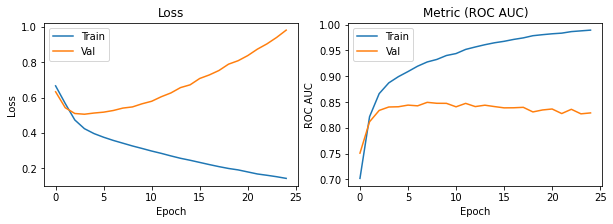

Лучший результат на валидации: 0.8494671767342226


In [ ]:
test_layer_size(layer_size=100, num_layers=2, num_epochs=25, show=True);

Попробуем сделать размер скрытых слоев разным:

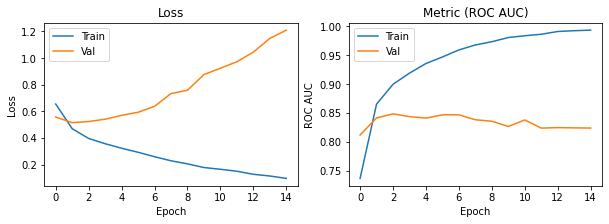

0.8484430840464289

In [ ]:
model = nn.Sequential(
          nn.Linear(X_train.shape[1], 500),
          nn.ReLU(),
          nn.Linear(500, 250),
          nn.ReLU(),
          nn.Linear(250, 100),
          nn.ReLU(),
          nn.Linear(100, 20),
          nn.ReLU(),
          nn.Linear(20, 1),
        )
model.to(device)
train_model(model, train_dataloader, val_dataloader, device=device, num_epochs=15, show=True)

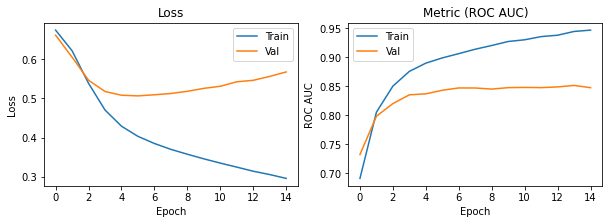

0.8513346008734256

In [ ]:
model = nn.Sequential(
          nn.Linear(X_train.shape[1], 100),
          nn.ReLU(),
          nn.Linear(100, 20),
          nn.ReLU(),
          nn.Linear(20, 1),
        )
model.to(device)
train_model(model, train_dataloader, val_dataloader, device=device, num_epochs=15, show=True)

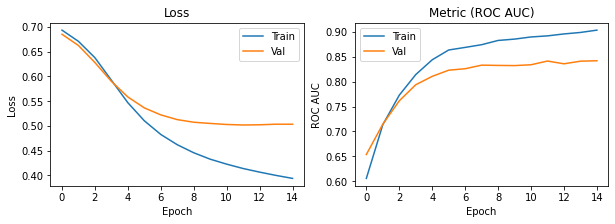

0.8418943671882889

In [ ]:
model = nn.Sequential(
          nn.Linear(X_train.shape[1], 10),
          nn.ReLU(),
          nn.Linear(10, 20),
          nn.ReLU(),
          nn.Linear(20, 1),
        )
model.to(device)
train_model(model, train_dataloader, val_dataloader, device=device, num_epochs=15, show=True)

Нет заметного эффекта

Посмотрим на влияние BatchNorm:

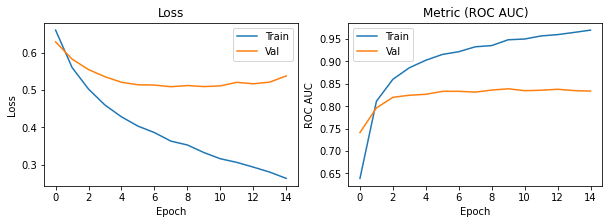

0.8386771791302364

In [ ]:
model = nn.Sequential(
          nn.Linear(X_train.shape[1], 100),
          nn.ReLU(),
          nn.BatchNorm1d(100),
          nn.Linear(100, 20),
          nn.ReLU(),
          nn.BatchNorm1d(20),
          nn.Linear(20, 1),
        )
model.to(device)
train_model(model, train_dataloader, val_dataloader, device=device, num_epochs=15, show=True)

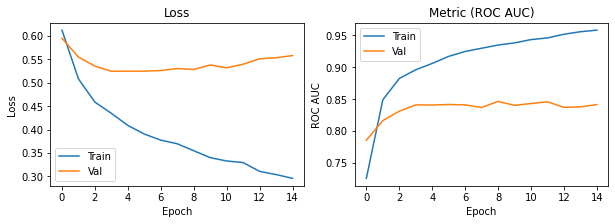

0.8463737475306583

In [ ]:
model = nn.Sequential(
          nn.Linear(X_train.shape[1], 100),
          nn.ReLU(),
          nn.BatchNorm1d(100),
          nn.Linear(100, 1),
        )
model.to(device)
train_model(model, train_dataloader, val_dataloader, device=device, num_epochs=15, show=True)

BatchNorm тоже не улучшил результат :(

Осталось посмотреть на Dropout:

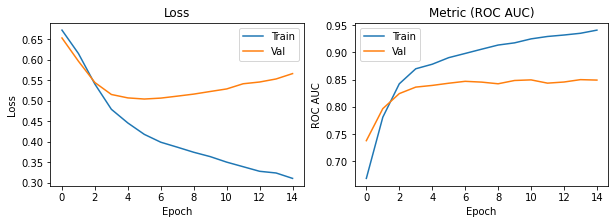

0.8500810291754991

In [ ]:
model = nn.Sequential(
          nn.Linear(X_train.shape[1], 100),
          nn.ReLU(),
          nn.Linear(100, 20),
          nn.Dropout(p=0.2),
          nn.ReLU(),
          nn.Linear(20, 1),
        )
model.to(device)
train_model(model, train_dataloader, val_dataloader, device=device, num_epochs=15, show=True)

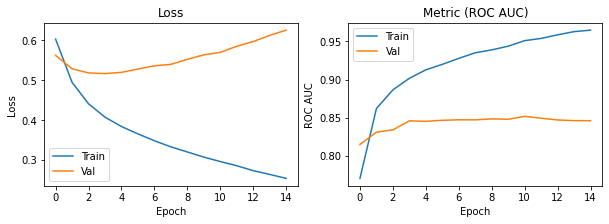

0.8517518791988865

In [ ]:
model = nn.Sequential(
          nn.Linear(X_train.shape[1], 1000),
          nn.Dropout(p=0.2),
          nn.ReLU(),
          nn.Linear(1000, 1),
        )
model.to(device)
train_model(model, train_dataloader, val_dataloader, device=device, num_epochs=15, show=True)

Картинка по лоссу и метрике на валидации почти не поменялась, переобучение не сдвинулось вправо

В такой неглубокой архитектуре смысла в дропауте нет, а для более глубокой архитектуры маловато данных

# Feature importance

В нейронных сетях нельзя напрямую посмотреть важность признаков. Но можно посмотреть на SHAP-values или попробовать выкидывать различные признаки из модели и смотреть, упадет ли качество

Посмотрим SHAP-values:

In [ ]:
e = shap.DeepExplainer(
        model, 
        torch.tensor(X_train.values, dtype=torch.float32).to(device)
    )

shap_values = e.shap_values(
    torch.tensor(X_train.values, dtype=torch.float32).to(device)
)












/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


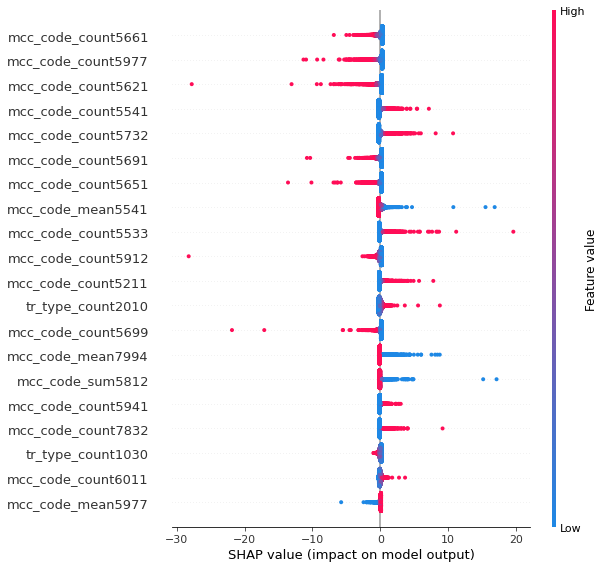

In [ ]:
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns)

Многие признаки совпадают с важными признаками, выделенными XGBoost-ом

# Сравнение с другими методами классификации

```markdown
Модель                    | ROC AUC 
--------------------------|------------------
Наивный Байес             | 0.630 
Метод опорных векторов    | 0.633
DecisionTree              | 0.659
Квадратичный дискриминант | 0.675
Линейный дискриминант     | 0.802
RandomForest              | 0.826
XGBoost                   | 0.879
--------------------------|-------------------
Neural Network            | 0.851
```

Видим, что бустинг оказался сильнее простой нейросети. На самом деле, это не удивительно - для работы с табличными данными бустинг подходит больше. Есть, конечно, специфические архитектуры, которые сравнимы с бустингом и даже превосходят его - TabNet, NODE. Но чаще всего нейросеть для табличных данных - это 2-3 слоя, и применяется она в стэкинге с другими моделями